In [1]:
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import json

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import itertools
from math import radians, cos, sin, asin, sqrt

In [3]:
# This is a mockup of what would be **Jiheng's list**.
     
import itertools
import random

zipcodedistance = pd.read_csv("ZipcodeDistance.csv")

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    meters = 6373 * 1000 * c
    return meters

In [4]:
g=open('input_files/uniqueCitiBikeZips.txt')
cbikelist = map(int, g.read().split("\n")[0].split("\t")[:-1])

In [5]:
dist_dict = {}
for subset in itertools.product(cbikelist,cbikelist):
    lon1 = zipcodedistance['Longitude'][zipcodedistance['Zip'] == subset[0]]
    lat1 = zipcodedistance['Latitude'][zipcodedistance['Zip'] == subset[0]]
    lon2 = zipcodedistance['Longitude'][zipcodedistance['Zip'] == subset[1]]
    lat2 = zipcodedistance['Latitude'][zipcodedistance['Zip'] == subset[1]]
    dist_dict[str(subset[0])+str(subset[1])] = haversine(lon1, lat1, lon2, lat2)

In [6]:
"""
Create pairs for total trips
"""

f = open('./results/results_TotalJanMaySept', 'r')
pairs = f.read().split("\n")

dict_total = {}
zip_pair_pre = None
cnt = 0
tm_list = []
mode_list = []
for item in pairs[:-1]:
    #print(item)
    trip, av_time, count = item.split("\t") #  
    zip_pair, mode = trip.split("|")
    zip_origin, zip_destin = zip_pair[:5], zip_pair[5:]
    if zip_pair == zip_pair_pre:
        cnt += 1
    else:
        if cnt == 2 and len(set(mode_list))==2:
            # Taxis - Citi bike
            #dict_total[zip_pair_pre] = [100*((float(tm_list[-2:][1]) - float(tm_list[-2:][0]) )/ float(tm_list[-2:][1])), dist_dict[zip_pair_pre] ]
            # Structure of the dictionay values: difference (taxis - bikes), distance, Citi Bike time, Taxi time.            
            dict_total[zip_pair_pre] = [float(tm_list[-2:][1]) - float(tm_list[-2:][0]) , dist_dict[zip_pair_pre] ,float(tm_list[-2:][0]) ,float(tm_list[-2:][1]), 100*(float(tm_list[-2:][1]) - float(tm_list[-2:][0]))/float(tm_list[-2:][1])  ]
            #print("yup!")
            tm_list = []
            mode_list = []
        cnt=1
    zip_pair_pre = zip_pair
    tm_list.append(av_time)
    mode_list.append(mode)

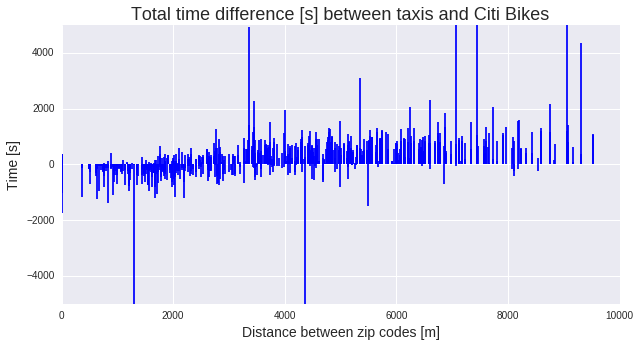

In [67]:
plt.figure(figsize=(10,5))
plt.vlines([val[1] for val in dict_total.values()], [10],[val[0] for val in dict_total.values()],color='blue')
plt.ylim(-5000, 5000)
plt.title("Total time difference [s] between taxis and Citi Bikes",fontsize=18)
plt.xlabel("Distance between zip codes [m]",fontsize=14)
plt.ylabel("Time [s]",fontsize=14)
savefig('./plots/Total.png')

In [8]:
from scipy import interpolate
from scipy import ndimage
"""
y = np.array([val[1] for val in dict_total.values()])
x = np.array([val[0] for val in dict_total.values()])
#fig = sns.kdeplot(to,shade=True)
x_smooth = np.linspace(x.min(), x.max(), 200)

# spline - always goes through all the data points x/y
#y_spline = interpolate.spline(x, y, x_smooth)
y_1D = interpolate.interp1d(x, y)


plt.scatter(x,y)
"""
#plt.xticks([val[0] for val in dict_total.values()])
#fig = sns.kdeplot(cjjardim, shade=True, color=c2,cut =0, clip=(0,2000))

'\ny = np.array([val[1] for val in dict_total.values()])\nx = np.array([val[0] for val in dict_total.values()])\n#fig = sns.kdeplot(to,shade=True)\nx_smooth = np.linspace(x.min(), x.max(), 200)\n\n# spline - always goes through all the data points x/y\n#y_spline = interpolate.spline(x, y, x_smooth)\ny_1D = interpolate.interp1d(x, y)\n\n\nplt.scatter(x,y)\n'

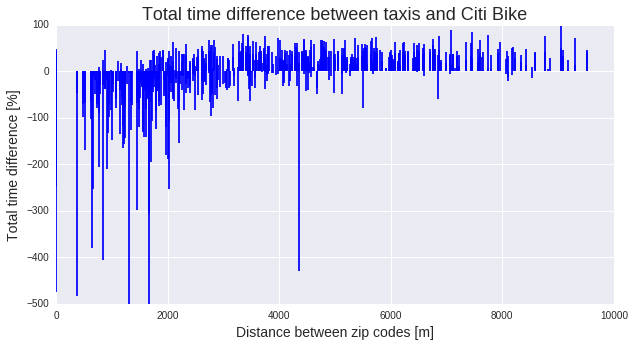

In [65]:
plt.figure(figsize=(10,5))
plt.vlines([val[1] for val in dict_total.values()], [0],[val[4] for val in dict_total.values()],color='blue')
plt.ylim(-500, 100)
plt.xlabel("Distance between zip codes [m]",fontsize=14)
plt.ylabel("Total time difference [%]",fontsize=14)
plt.title("Total time difference between taxis and Citi Bike",fontsize=18)
savefig('./plots/Total_percentage.png')

Mean for Citi bike: 1095.32880099
Mean for Taxis: 1386.84177998


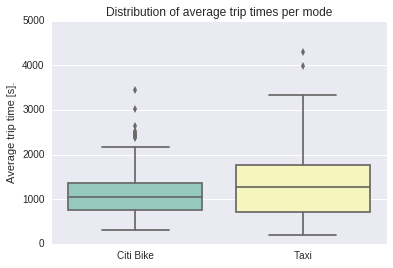

In [34]:
Total_trips = pd.DataFrame({"Citi Bike": [val[2] for val in dict_total.values()], "Taxi":[val[3] for val in dict_total.values()]},columns=["Citi Bike","Taxi"])
    
print "Mean for Citi bike: "+str(np.mean([val[2] for val in dict_total.values()]))
print "Mean for Taxis: " +str(np.mean([val[3] for val in dict_total.values()]))

ax = sns.boxplot(Total_trips,palette="Set3")
ax.set_ylim(0,5000)
ax.set( ylabel= "Average trip time [s].")
ax.set(title= "Distribution of average trip times per mode")
savefig('./plots/Average_times_mode.png')

In [11]:
"""

Crete pairs for weekday rush vs. non-rush scenarios.

"""

g = open('./results/results_RushJanMaySept', 'r')
pairs = g.read().split("\n")

dict_rush = {}
zip_pair_pre = None
cnt = 0
tm_list = []
mode_list = []
for item in pairs[:-1]:
    #print(item)
    trip, av_time, count = item.split("\t") #  
    zip_pair, form = trip.split("|")
    mode, rush = form.split("&")
    zip_origin, zip_destin = zip_pair[:5], zip_pair[5:]
    if zip_pair == zip_pair_pre:
        cnt += 1
    else:
        if cnt == 4 and len(set(mode_list))==2:
            # citibike&rush, citibike&valley, taxis&rush, taxis&valley 
            # Taxi - Citi bike rush, Taxi - Citi Bike non rush, distance, percentual difference rush, percentual difference non rush
            dict_rush[zip_pair_pre] = [['rush','valley'],  float(tm_list[-4:][2]) - float(tm_list[-4:][0]),float(tm_list[-4:][3]) - float(tm_list[-4:][1]), dist_dict[zip_pair_pre],100*(float(tm_list[-4:][2]) - float(tm_list[-4:][0]))/float(tm_list[-4:][2]),100*(float(tm_list[-4:][3]) - float(tm_list[-4:][1]))/float(tm_list[-4:][3])] #100*((float(tm_list[-2:][1]) - float(tm_list[-2:][0]) )/ float(tm_list[-2:][1])) 
            #print("Si")
            tm_list = []
            mode_list = []
        cnt=1
    zip_pair_pre = zip_pair
    tm_list.append(av_time)
    mode_list.append(mode)

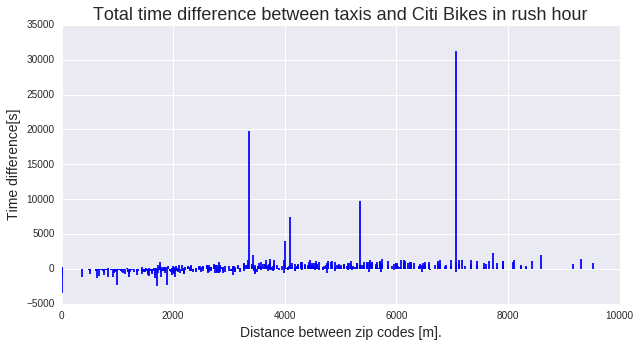

In [64]:
plt.figure(figsize=(10,5))
plt.vlines([val[3] for val in dict_rush.values()], [0],[val[1] for val in dict_rush.values()],color='blue')
#plt.ylim(-2000, 7000)
plt.xlabel("Distance between zip codes [m].",fontsize=14)
plt.ylabel("Time difference[s]",fontsize=14)
plt.title("Total time difference between taxis and Citi Bikes in rush hour",fontsize=18)
savefig('./plots/Rush_difference.png')

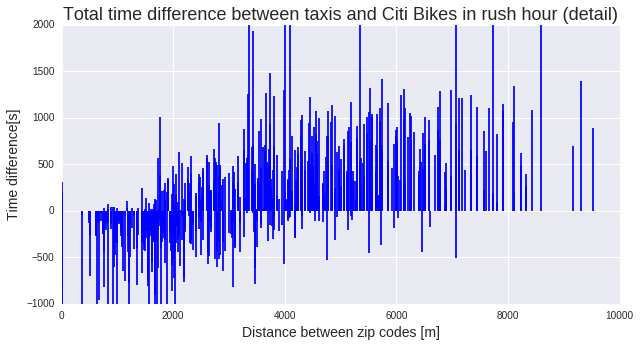

In [63]:
plt.figure(figsize=(10,5))
plt.vlines([val[3] for val in dict_rush.values()], [0],[val[1] for val in dict_rush.values()],color='blue')
plt.ylim(-1000, 2000)
plt.xlabel("Distance between zip codes [m]",fontsize=14)
plt.ylabel("Time difference[s]",fontsize=14)
plt.title("Total time difference between taxis and Citi Bikes in rush hour (detail)",fontsize=18)
savefig('./plots/Rush_difference_detail.png')

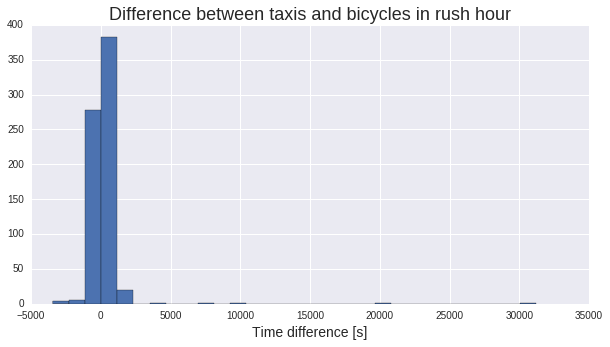

In [61]:
plt.figure(figsize=(10,5))
plt.hist([val[1] for val in dict_rush.values()],bins=30)
plt.title("Difference between taxis and bicycles in rush hour",fontsize=18)
plt.xlabel("Time difference [s]",fontsize=14)
savefig('./plots/rushHourHistogram.png')

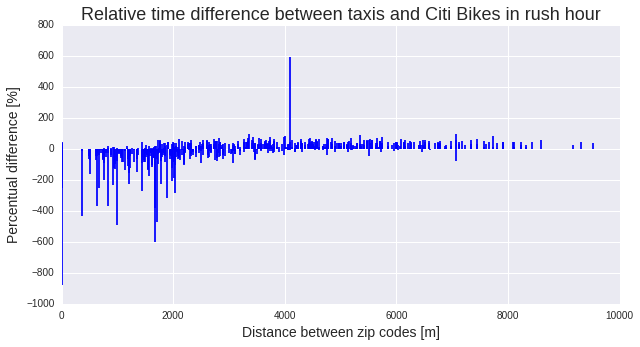

In [58]:
plt.figure(figsize=(10,5))
plt.vlines([val[3] for val in dict_rush.values()], [0],[val[4] for val in dict_rush.values()],color='blue')
plt.ylim(-1000, 800)
plt.xlabel("Distance between zip codes [m]",fontsize=14)
plt.title("Relative time difference between taxis and Citi Bikes in rush hour",fontsize=18)
plt.ylabel("Percentual difference [%]",fontsize=14)
savefig('./plots/Rush_percentage.png')

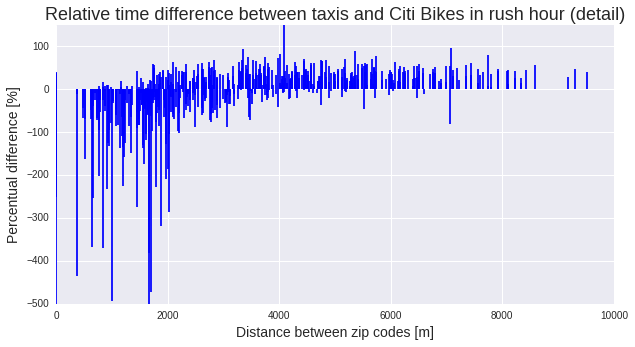

In [59]:
plt.figure(figsize=(10,5))
plt.vlines([val[3] for val in dict_rush.values()], [0],[val[4] for val in dict_rush.values()],color='blue')
plt.ylim(-500, 150)
plt.xlabel("Distance between zip codes [m]",fontsize=14)
plt.title("Relative time difference between taxis and Citi Bikes in rush hour (detail)",fontsize=18)
plt.ylabel("Percentual difference [%]",fontsize=14)
savefig('./plots/Rush_percentage_detail.png')

Mean difference in rush hour: 253.708933718
Mean difference in non rush hour: -154.808357349


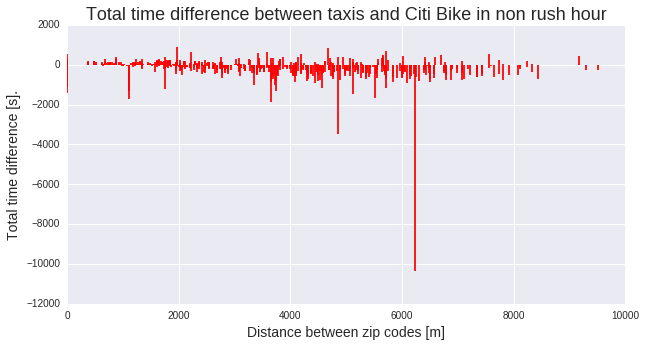

In [54]:
plt.figure(figsize=(10,5))
plt.vlines([val[3] for val in dict_rush.values()], [0],[val[2] for val in dict_rush.values()],color='red')
plt.xlabel("Distance between zip codes [m]",fontsize=14)
plt.ylabel("Total time difference [s].",fontsize=14)
plt.title("Total time difference between taxis and Citi Bike in non rush hour",fontsize=18)
savefig('./plots/nonRush_difference.png')

print "Mean difference in rush hour: "+str(np.mean([val[1] for val in dict_rush.values()]))
print "Mean difference in non rush hour: " +str(np.mean([val[2] for val in dict_rush.values()]))

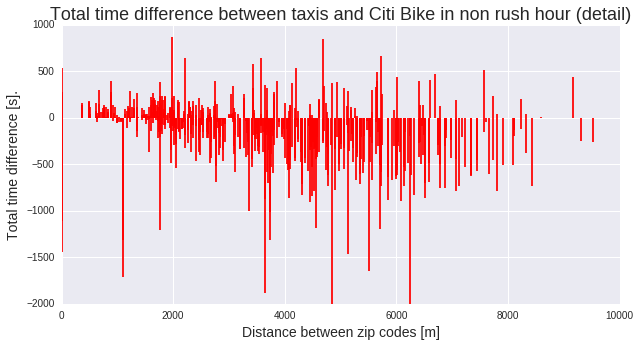

In [55]:
plt.figure(figsize=(10,5))
plt.vlines([val[3] for val in dict_rush.values()], [0],[val[2] for val in dict_rush.values()],color='red')
plt.xlabel("Distance between zip codes [m]",fontsize=14)
plt.ylim(-2000,1000)
plt.ylabel("Total time difference [s].",fontsize=14)
plt.title("Total time difference between taxis and Citi Bike in non rush hour (detail)",fontsize=18)
savefig('./plots/nonRush_difference_detail.png')

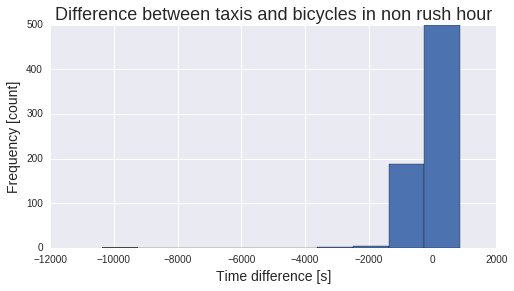

In [68]:
plt.figure(figsize=(8,4))
plt.hist([val[2] for val in dict_rush.values()])
plt.title("Difference between taxis and bicycles in non rush hour",fontsize=18)
plt.xlabel("Time difference [s]",fontsize=14)
plt.ylabel("Frequency [count]",fontsize=14)
savefig('./plots/nonRush_histogram.png')

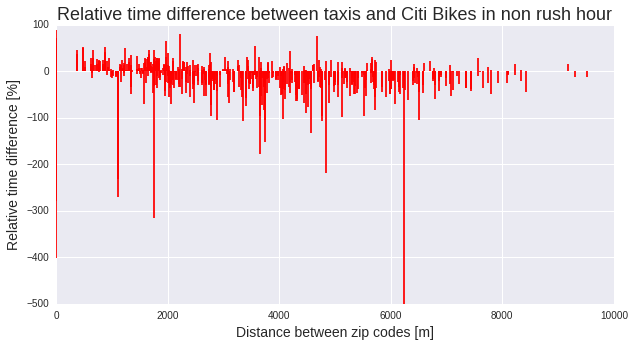

In [43]:
plt.figure(figsize=(10,5))
plt.vlines([val[3] for val in dict_rush.values()], [0],[val[5] for val in dict_rush.values()],color='red')
plt.ylim(-500,100)
plt.xlabel("Distance between zip codes [m]",fontsize=14)
plt.ylabel("Relative time difference [%]",fontsize=14)
plt.title("Relative time difference between taxis and Citi Bikes in non rush hour",fontsize=18)
savefig('./plots/nonRush_percentage.png')

In [21]:
"""

Create pairs for weekend day vs-night scenarios.

"""
    
h = open('./results/results_SaturdayJanMaySept', 'r')
pairs = h.read().split("\n")

dict_weekend = {}
zip_pair_pre = None
cnt = 0
tm_list = []
mode_list = []
for item in pairs[:-1]:
    #print(item)
    trip, av_time, count = item.split("\t") #  
    zip_pair, form = trip.split("|")
    mode, rush = form.split("&")
    zip_origin, zip_destin = zip_pair[:5], zip_pair[5:]
    if zip_pair == zip_pair_pre:
        cnt += 1
    else:
        if cnt == 4 and len(set(mode_list))==2:
            # citibike&day, citibike&night, taxis&day, taxis&night  
            dict_weekend[zip_pair_pre] = [['day','night'],  float(tm_list[-4:][2]) - float(tm_list[-4:][0]) ,float(tm_list[-4:][3]) - float(tm_list[-4:][1]), dist_dict[zip_pair_pre] , 100*(float(tm_list[-4:][2]) - float(tm_list[-4:][0]))/float(tm_list[-4:][2]),100*(float(tm_list[-4:][3]) - float(tm_list[-4:][1]))/float(tm_list[-4:][3])  ] #100*((float(tm_list[-2:][1]) - float(tm_list[-2:][0]) )/ float(tm_list[-2:][1])) 
            #print("Si")
            tm_list = []
            mode_list = []
        cnt=1
    zip_pair_pre = zip_pair
    tm_list.append(av_time)
    mode_list.append(mode)

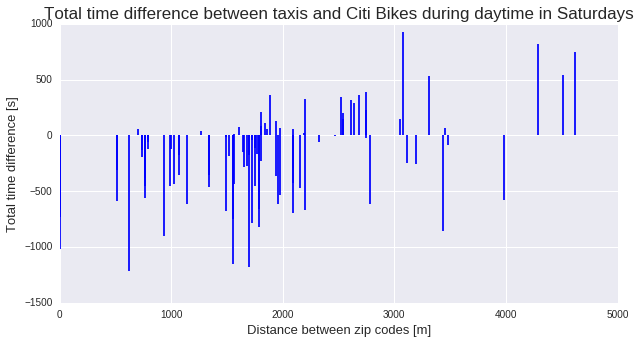

In [53]:
plt.figure(figsize=(10,5))
plt.vlines([val[3] for val in dict_weekend.values()], [0],[val[1] for val in dict_weekend.values()],color='blue')
plt.xlabel("Distance between zip codes [m]",fontsize=13)
plt.title("Total time difference between taxis and Citi Bikes during daytime in Saturdays",fontsize=17)
plt.ylabel("Total time difference [s]",fontsize=13)
savefig('./plots/saturday_difference.png')

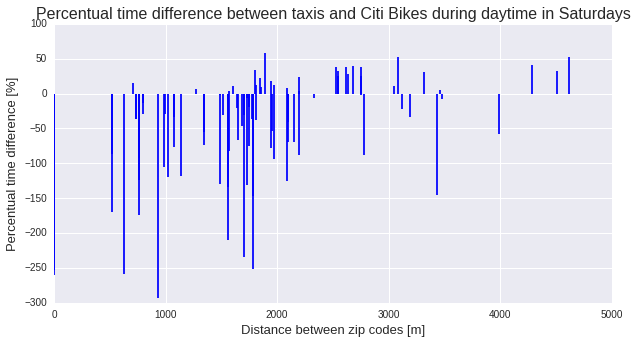

In [50]:
plt.figure(figsize=(10,5))
plt.vlines([val[3] for val in dict_weekend.values()], [0],[val[4] for val in dict_weekend.values()],color='blue')
plt.xlabel("Distance between zip codes [m]",fontsize=13)
plt.ylabel("Percentual time difference [%]",fontsize=13)
plt.title("Percentual time difference between taxis and Citi Bikes during daytime in Saturdays",fontsize=16)
savefig('./plots/saturday_relative.png')

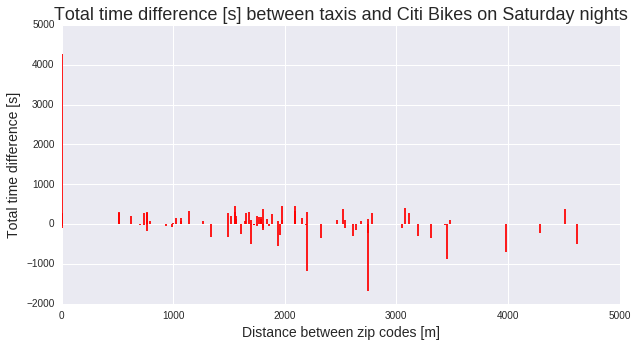

In [49]:
plt.figure(figsize=(10,5))
plt.vlines([val[3] for val in dict_weekend.values()], [0],[val[2] for val in dict_weekend.values()],color='red')
plt.xlabel("Distance between zip codes [m]",fontsize=14)
plt.title("Total time difference [s] between taxis and Citi Bikes on Saturday nights",fontsize=18)
plt.ylabel("Total time difference [s]",fontsize=14)
savefig('./plots/saturnight_difference.png')

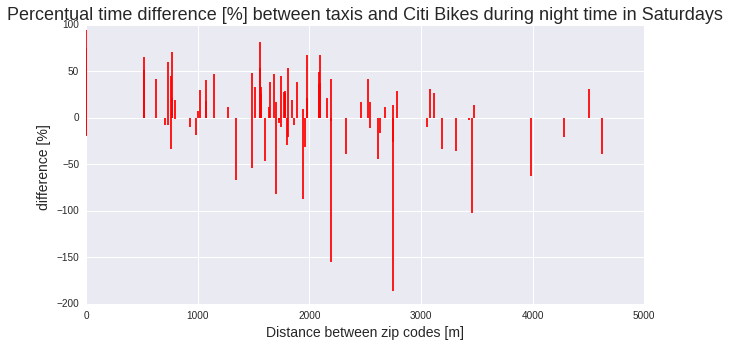

In [48]:
plt.figure(figsize=(10,5))
plt.vlines([val[3] for val in dict_weekend.values()], [0],[val[5] for val in dict_weekend.values()],color='red')
plt.xlabel("Distance between zip codes [m]",fontsize=14)
plt.title("Percentual time difference [%] between taxis and Citi Bikes during night time in Saturdays",fontsize=18)
plt.ylabel("difference [%] ",fontsize=14)
savefig('./plots/saturnight_relative.png')

In [26]:
print "Mean difference on Saturday daytime: "+str(np.mean([val[1] for val in dict_weekend.values()]))
print "Mean difference on Saturday night: " +str(np.mean([val[2] for val in dict_weekend.values()]))

Mean difference on Saturday daytime: -215.936842105
Mean difference on Saturday night: 65.8421052632


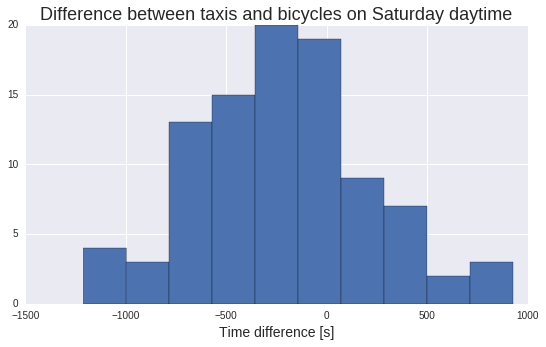

In [51]:
plt.figure(figsize=(9,5))
plt.hist([val[1] for val in dict_weekend.values()])
plt.title("Difference between taxis and bicycles on Saturday daytime",fontsize=18)
plt.xlabel("Time difference [s]",fontsize=14)
savefig('./plots/saturDAY_hist.png')

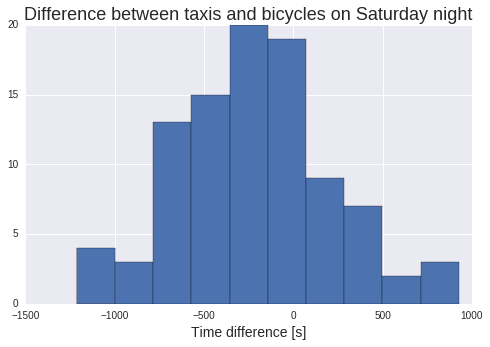

In [52]:
plt.figure(figsize=(8,5))
plt.hist([val[1] for val in dict_weekend.values()])
plt.title("Difference between taxis and bicycles on Saturday night",fontsize=18)
plt.xlabel("Time difference [s]",fontsize=14)
savefig('./plots/saturnigth_hist.png')

In [29]:
# -- Save dictionaries in json files  
  
import json
with open('./results/total_trips.json', 'w') as fp:
    json.dump(dict_total, fp)
    
with open('./results/rush_nonrush.json', 'w') as fp:
    json.dump(dict_rush, fp)

with open('./results/total_weekends.json', 'w') as fp:
    json.dump(dict_weekend, fp)  
     